#### Build a image x label adjacency matrix (oh i miss babai)

In [1]:
import os
import numpy as np
import re
import csv
import glob
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
DATA_DIRECTORY = "../../../project/rcc/deep_learning_hack/netdissect/broden1_224/"
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/"

categories_pixels = ['color', 'object', 'part', 'material']
categories_scalars = ['scene', 'texture']

In [3]:
def decode_index_dict(row):
    result = {}
    for key, val in row.items():
        if key in ['image', 'split']:
            result[key] = val
        elif key in ['sw', 'sh', 'iw', 'ih']:
            result[key] = int(val)
        else:
            item = [s for s in val.split(';') if s]
            for i, v in enumerate(item):
                if re.match('^\d+$', v):
                    item[i] = int(v)
            result[key] = item
    return result

In [4]:
def decode_label_dict(row):
    result = {}
    for key, val in row.items():
        if key == 'category':
            result[key] = dict((c, int(n))
                for c, n in [re.match('^([^(]*)\(([^)]*)\)$', f).groups()
                    for f in val.split(';')])
        elif key == 'name':
            result[key] = val
        elif key == 'syns':
            result[key] = val.split(';')
        elif re.match('^\d+$', val):
            result[key] = int(val)
        elif re.match('^\d+\.\d*$', val):
            result[key] = float(val)
        else:
            result[key] = val
    return result

In [5]:
with open(os.path.join(DATA_DIRECTORY, "index.csv")) as f:
    images = [decode_index_dict(r) for r in csv.DictReader(f)]

In [6]:
with open(os.path.join(DATA_DIRECTORY, "label.csv")) as f:
    labels = [decode_label_dict(r) for r in csv.DictReader(f)]

In [7]:
labels

[{'number': 1,
  'name': 'black-c',
  'category': {'color': 62358},
  'frequency': 62358,
  'coverage': 11135.320474,
  'syns': ['']},
 {'number': 2,
  'name': 'grey-c',
  'category': {'color': 62310},
  'frequency': 62310,
  'coverage': 12712.843129,
  'syns': ['']},
 {'number': 3,
  'name': 'white-c',
  'category': {'color': 62054},
  'frequency': 62054,
  'coverage': 5778.038204,
  'syns': ['']},
 {'number': 4,
  'name': 'brown-c',
  'category': {'color': 61583},
  'frequency': 61583,
  'coverage': 14549.652454,
  'syns': ['']},
 {'number': 5,
  'name': 'green-c',
  'category': {'color': 61508},
  'frequency': 61508,
  'coverage': 5049.989735,
  'syns': ['']},
 {'number': 6,
  'name': 'pink-c',
  'category': {'color': 60755},
  'frequency': 60755,
  'coverage': 1478.518582,
  'syns': ['']},
 {'number': 7,
  'name': 'purple-c',
  'category': {'color': 59516},
  'frequency': 59516,
  'coverage': 865.041519,
  'syns': ['']},
 {'number': 8,
  'name': 'blue-c',
  'category': {'color': 57

In [8]:
images

[{'image': 'opensurfaces/25605.jpg',
  'split': 'train',
  'ih': 224,
  'iw': 224,
  'sh': 112,
  'sw': 112,
  'color': ['opensurfaces/25605_color.png'],
  'object': [],
  'part': [],
  'material': ['opensurfaces/25605_material.png'],
  'scene': [],
  'texture': []},
 {'image': 'opensurfaces/24183.jpg',
  'split': 'train',
  'ih': 224,
  'iw': 224,
  'sh': 112,
  'sw': 112,
  'color': ['opensurfaces/24183_color.png'],
  'object': [],
  'part': [],
  'material': ['opensurfaces/24183_material.png'],
  'scene': [],
  'texture': []},
 {'image': 'opensurfaces/72705.jpg',
  'split': 'train',
  'ih': 224,
  'iw': 224,
  'sh': 112,
  'sw': 112,
  'color': ['opensurfaces/72705_color.png'],
  'object': [],
  'part': [],
  'material': ['opensurfaces/72705_material.png'],
  'scene': [],
  'texture': []},
 {'image': 'opensurfaces/100509.jpg',
  'split': 'train',
  'ih': 224,
  'iw': 224,
  'sh': 112,
  'sw': 112,
  'color': ['opensurfaces/100509_color.png'],
  'object': [],
  'part': [],
  'materia

In [9]:
def build_image_vs_label(images, labels, save_path="matrix.npy"):
    if not os.path.exists(os.path.join(OUTPUT_FOLDER, "visualization")):
        os.makedirs(os.path.join(OUTPUT_FOLDER, 'visualization'))
    save_path = os.path.join(OUTPUT_FOLDER, "visualization", save_path)
    if os.path.exists(save_path):
        print("loading")
        return np.load(save_path)
    
    image_vs_label = np.zeros((len(images), len(labels)+1))
    for i, image in enumerate(images):
        if (i % 100 == 0):
            print(i)
        lbs = np.array([])
        for cat in categories_pixels:
            for lb_img in image[cat]:
                lb_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb_img))
                cat_lbs = np.unique(np.array(list(lb_img.getdata())))[1:]
                lbs = np.concatenate((lbs, cat_lbs))
        for cat in categories_scalars:
            lbs = np.concatenate((lbs, np.array(image[cat])))
        lbs = np.unique(lbs.astype(int))
        image_vs_label[i].put(lbs, [1])
    np.save(save_path, image_vs_label)
    return image_vs_label

In [10]:
ivl = build_image_vs_label(images, labels)

loading


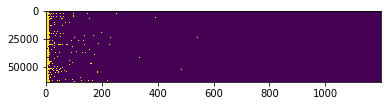

In [42]:
plt.imshow(ivl, aspect=0.004)